In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import copy
import nugget
from conflictfree.grad_operator import ConFIG_update
import time
from scipy.stats import gaussian_kde
from IPython.display import clear_output
import matplotlib.pyplot as plt
import importlib

In [2]:
Skewedgauss = nugget.surrogates.SkewedGaussian.SkewedGaussian()
light_yield_surrogate = Skewedgauss.light_yield_surrogate
signal_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=1)
background_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=-1)


In [3]:
llr_net = nugget.surrogates.LLRnet.LLRnet(
    dim=3,
    hidden_dims=[256, 128, 64],
    use_fourier_features=True,
    num_parallel_branches=2,
    frequency_scales=[0.1, 0.2],  # Different scales for each branch
    num_frequencies_per_branch=[64,64],
    learnable_frequencies=False,
    dropout_rate=0.1,
    learning_rate=1e-3,
    shared_mlp=False,  # Use shared MLP across branches
    use_residual_connections=True,
    signal_noise_scale=0.05,
    background_noise_scale=0.2,
    add_relative_pos=True
)

In [4]:
train_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler, 
                                                   background_sampler = background_sampler,
                                                   batch_size=64, 
                                                   num_workers=2,
                                                   signal_surrogate_func=light_yield_surrogate,
                                                   background_surrogate_func=light_yield_surrogate,
                                                   num_samples_per_epoch=3000,
                                                   event_labels=['position', 'energy', 'zenith', 'azimuth'])
val_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler,
                                                 background_sampler = background_sampler,
                                                 batch_size=2, 
                                                 num_workers=2,
                                                 signal_surrogate_func=light_yield_surrogate,
                                                 background_surrogate_func=light_yield_surrogate,
                                                 num_samples_per_epoch=1000,
                                                 event_labels=['position', 'energy', 'zenith', 'azimuth'])
test_dataloader = llr_net.create_event_dataloader(signal_sampler = signal_sampler,
                                                  background_sampler = background_sampler,
                                                  batch_size=1, 
                                                  num_workers=2,
                                                  signal_surrogate_func=light_yield_surrogate,
                                                  background_surrogate_func=light_yield_surrogate,
                                                  num_samples_per_epoch=1000,
                                                  event_labels=['position', 'energy', 'zenith', 'azimuth'])

In [5]:
history = llr_net.train_with_dataloader(train_dataloader=train_dataloader,
                                       val_dataloader=val_dataloader,
                                       epochs=200,
                                       early_stopping_patience=25)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Building parallel network architecture:
  Input dim: 15
  Number of parallel branches: 2
  Shared MLP: False
  Branch 0: 64 frequencies, scale 0.100, output dim 128
  Branch 1: 64 frequencies, scale 0.200, output dim 128
  Branch 0 MLP with residual connections: 128 -> [256, 128, 64] -> 64
  Branch 1 MLP with residual connections: 128 -> [256, 128, 64] -> 64
  Final MLP: 128 -> 64 -> 1
  Total trainable parameters: 247,297
  Total trainable parameters: 247,297


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 10/200, Train Loss: 0.0870, Val Loss: 0.0911
Epoch 20/200, Train Loss: 0.0855, Val Loss: 0.0593
Epoch 20/200, Train Loss: 0.0855, Val Loss: 0.0593
Epoch 30/200, Train Loss: 0.0827, Val Loss: 0.0545
Epoch 30/200, Train Loss: 0.0827, Val Loss: 0.0545
Epoch 40/200, Train Loss: 0.0782, Val Loss: 0.0718
Epoch 40/200, Train Loss: 0.0782, Val Loss: 0.0718
Epoch 50/200, Train Loss: 0.0744, Val Loss: 0.0657
Epoch 50/200, Train Loss: 0.0744, Val Loss: 0.0657
Epoch 60/200, Train Loss: 0.0707, Val Loss: 0.0654
Epoch 60/200, Train Loss: 0.0707, Val Loss: 0.0654
Early stopping at epoch 66
Early stopping at epoch 66


1000 1000 1000

Evaluation Results:
Accuracy: 0.9690
AUC: 0.9958
Precision: 0.9737
Recall: 0.9640

Evaluation Results:
Accuracy: 0.9690
AUC: 0.9958
Precision: 0.9737
Recall: 0.9640


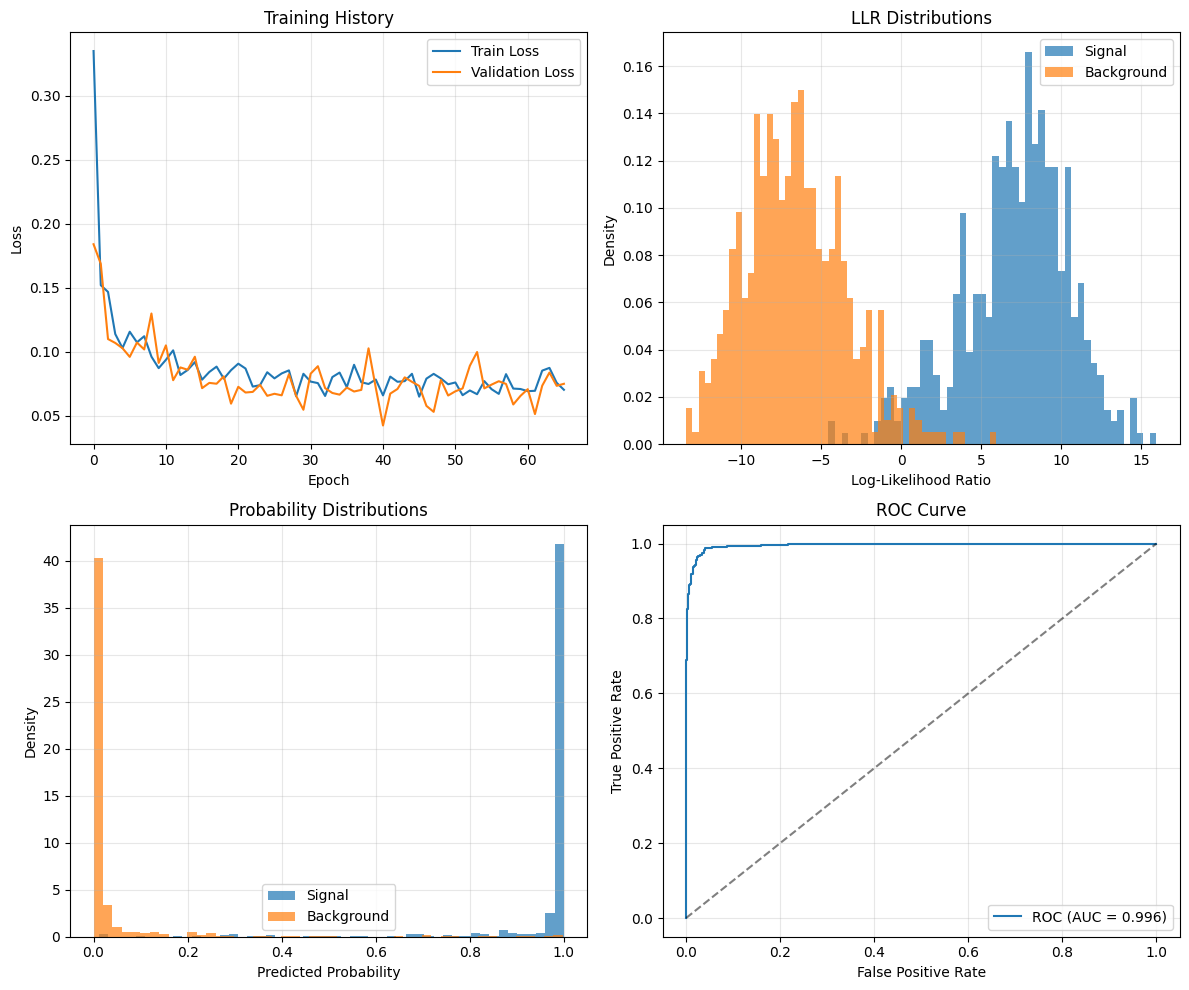

In [6]:
predictions = []
true_labels = []
llr_values = []
all_features = []
with torch.no_grad():
    for features, labels, in test_dataloader:
        # Get LLR predictions
        batch_llr = llr_net.predict_log_likelihood_ratio(features)
        batch_probs = llr_net.predict_proba(features)
        # print(len(batch_llr), len(batch_probs), len(labels))
        
        llr_values.extend(batch_llr.cpu().numpy())
        predictions.extend(batch_probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_features.extend(features.cpu().numpy())  # Store features for further analysis
        # denoised_values.extend(denoised.cpu().numpy())

# Convert to numpy arrays
llr_values = np.array(llr_values)
predictions = np.array(predictions)
true_labels = np.array(true_labels)
all_features = np.array(all_features).squeeze()  # Remove batch dimension if needed
# denoised_values = np.array(denoised_values)
print(len(llr_values), len(predictions), len(true_labels))

# Evaluate performance
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

binary_preds = (predictions > 0.5).astype(int)
accuracy = accuracy_score(true_labels, binary_preds)
auc = roc_auc_score(true_labels, predictions)
precision = precision_score(true_labels, binary_preds)
recall = recall_score(true_labels, binary_preds)

print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training history
axes[0,0].plot(history['train_loss'], label='Train Loss')
axes[0,0].plot(history['val_loss'], label='Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].set_title('Training History')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# LLR distributions
signal_mask = true_labels == 1
background_mask = true_labels == 0

axes[0,1].hist(llr_values[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[0,1].hist(llr_values[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[0,1].set_xlabel('Log-Likelihood Ratio')
axes[0,1].set_ylabel('Density')
axes[0,1].set_title('LLR Distributions')
# axes[0,1].set_xlim(-5, 5)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Probability distributions
axes[1,0].hist(predictions[signal_mask], bins=50, alpha=0.7, label='Signal', density=True)
axes[1,0].hist(predictions[background_mask], bins=50, alpha=0.7, label='Background', density=True)
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Probability Distributions')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
axes[1,1].plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})')
axes[1,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curve')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()